# Supervised Machine Learning Examples
## 1. Penalized Regression
## 2. Random Forest
## 3. Deep Neural Network

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = "C:/Users/jhtchns2/Box/ACE 592 SAE Spring 2022/Class Examples/4_Analysis/"

## 1. Penalized Regression Example

To demonstrate SML methods, we will be using a dataset of house prices used in a Kaggle competition.

In [2]:
df = pd.read_csv("./housing_train.csv")

df.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Saleprice
0,1,18.144573,13.833054,7,3.991517,2003,2003,19.433175,144.117862,0.0,...,0,0,1,0,0,0,0,1,0,208501.0
1,2,20.673625,14.117918,6,6.000033,1976,1976,54.598150,181.719186,0.0,...,0,0,1,0,0,0,0,1,0,181501.0
2,3,18.668047,14.476512,7,3.991517,2001,2002,17.768840,110.441033,0.0,...,0,0,1,0,0,0,0,1,0,223501.0
3,4,17.249651,14.106196,7,3.991517,1915,1970,54.598150,61.795315,0.0,...,0,0,1,1,0,0,0,0,0,140001.0
4,5,21.314283,15.022008,8,3.991517,2000,2000,25.404164,136.624601,0.0,...,0,0,1,0,0,0,0,1,0,250001.0


<Axes: ylabel='Frequency'>

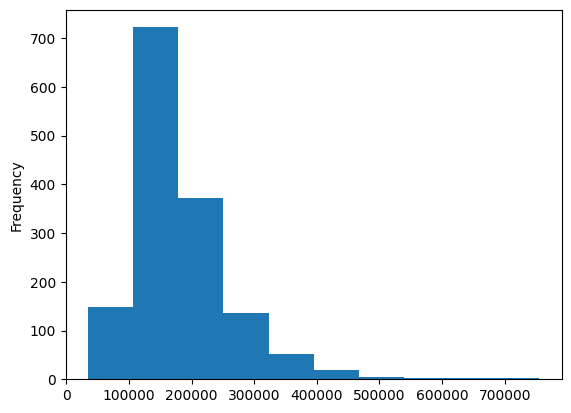

In [3]:
df['Saleprice'].plot(kind="hist")

Some minor data cleaning

In [4]:
df['decade'] = df['YearBuilt'].apply(lambda x: str(x)[:3]) + "0"

decades = pd.get_dummies(df.decade)

decades.columns = ["decade_"+x for x in decades.columns]

df = pd.concat([df,decades],axis=1)

In [5]:
df = df.dropna()

How many features could we use to predict house prices?

In [6]:
features = list(df.columns)[1:5] + list(df.iloc[:,7:379].columns) + list(df.iloc[:,381:].columns)

len(features)

391

Oof! Is there any way we could reduce this down a little bit?

First let's scale the data.

In [7]:
X = StandardScaler().fit_transform(df[features])

y = StandardScaler().fit_transform(df[['Saleprice']])

Now let's instantiate a Lasso model. Recall that alpha here is how much we penalize large coefficients.

In [8]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=.1)

lasso_model = lasso_model.fit(y=y,X=X)

Now let's look at the coefficients:

In [9]:
lasso_model.coef_

array([ 0.        ,  0.04774875,  0.21571747,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.17535666,  0.        ,
        0.07229845, -0.        ,  0.1302813 ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.01353643,  0.        ,  0.        ,  0.03675669,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.08096833,  0.00256433,
        0.03290653,  0.        ,  0.08091889,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.  

Notice that it has zeroed out a bunch of coefficients.

In [10]:
bool_ = lasso_model.coef_!=0
print(sum(bool_))
df[features].iloc[:,bool_].columns

18


Index(['LotArea', 'OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
       'Fireplaces', 'GarageArea', 'Total_Home_Quality', 'TotalSF',
       'YrBltAndRemod', 'Total_Bathrooms', 'GarageCars_log_sq',
       'Neighborhood_NoRidge', 'ExterQual_Ex', 'ExterQual_TA', 'BsmtQual_Ex',
       'BsmtExposure_Gd', 'KitchenQual_Ex'],
      dtype='object')

So that's already an improvement! Here's what happen when we choose different values of alpha

In [11]:
def get_coefs(alpha,features,target):
    X = StandardScaler().fit_transform(df[features])
    y = StandardScaler().fit_transform(df[target])

    lasso_model =Lasso(alpha=alpha)
    lasso_model = lasso_model.fit(y=y,X=X)

    coefs = lasso_model.coef_

    return coefs

Alpha = np.arange(0,1,.01)

coef_lists = [list(get_coefs(a,df[features].iloc[:,bool_].columns,["Saleprice"])) for a in Alpha]


<ipython-input-11-09cde4858af5>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model = lasso_model.fit(y=y,X=X)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.337e+01, tolerance: 1.458e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'Coefficient')

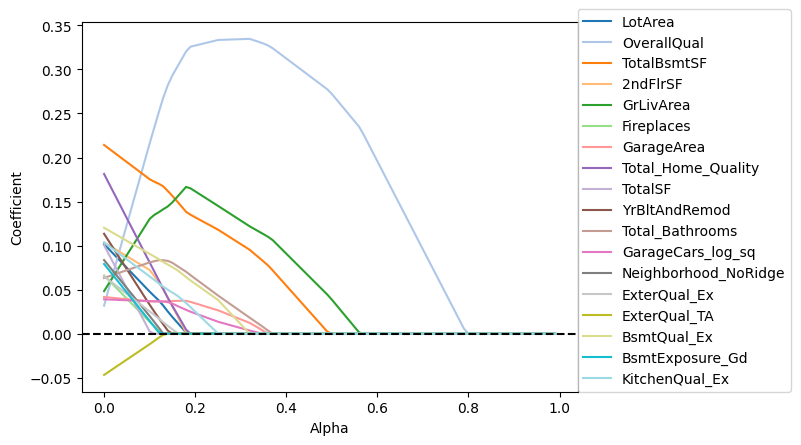

In [14]:
Coefs = pd.DataFrame(coef_lists)

Coefs.columns = df[features].iloc[:,bool_].columns
Coefs.index=Alpha

Coefs.plot(cmap="tab20")
plt.legend(loc=(1,0))
plt.axhline(0,ls="--",color="black")
plt.xlabel("Alpha")
plt.ylabel("Coefficient")

But how do we know we got the right value of alpha?

One way is to choose them based on __prediction error__. Let's use cross validation!

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = Lasso(alpha=.05).fit(X_train,y_train)

y_hat = model.predict(X_test)

rmse = ((y_hat - y_test[:,0])**2).mean()**.5
print("alpha = .05, RMSE =" + str(rmse))

model = Lasso(alpha=.15).fit(X_train,y_train)

y_hat = model.predict(X_test)

rmse = ((y_hat - y_test[:,0])**2).mean()**.5
print("alpha = .15, RMSE =" + str(rmse))

alpha = .05, RMSE =0.3659580308674737
alpha = .15, RMSE =0.4684793806918725


In [16]:
def get_alpha_rmse(alpha):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = Lasso(alpha=alpha).fit(X_train,y_train)

    y_hat = model.predict(X_test)

    rmse = ((y_hat - y_test[:,0])**2).mean()
    return rmse

In [17]:
A = np.arange(.0001,1,.001)

rmses = [get_alpha_rmse(a) for a in A]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+01, tolerance: 1.132e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e-01, tolerance: 1.132e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e-01, tolerance: 1.132e

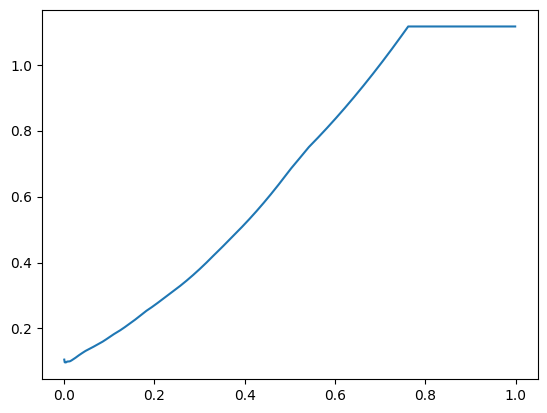

In [19]:
plt.plot(A,rmses)

So the lowest possible value is the best one.

We could have done this easier with the `LassoCV` function, which will do it with K-folds:

In [20]:
from sklearn.linear_model import LassoCV

Alpha = np.arange(0,1,.005)
lasso_model = LassoCV(alphas=A,cv=10)

lasso_model = lasso_model.fit(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3537807515284612, tolerance: 0.13496970798903496
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.933108938374836, tolerance: 0.13496970798903496
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objectiv

In [21]:
(lasso_model.coef_!=0).sum(),  lasso_model.alpha_

(196, 0.0031)

In [22]:
df['y_hat_lasso'] = lasso_model.predict(X)

In [23]:
rmse_lasso = ((y[:,0] - df['y_hat_lasso'])**2).mean()**.5

So it wanted to keep about half the variables, mainly because it picked a very small value of alpha. __What might we do in this case?__

Suppose that we wanted to train an __Elastic Net__ to check these results.

In [24]:
model = ElasticNet(alpha=.5,l1_ratio=.5)
model = model.fit(X,y)
model.coef_

array([ 0.        ,  0.        ,  0.19287968, -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.10316535,  0.        ,
        0.        , -0.        ,  0.06549987,  0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.01288429,  0.03103155,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.05913308,  0.        ,
        0.        ,  0.        ,  0.05457033,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.0401778 ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.  

How do we choose two parameters at once?

This is where we can us `GridSearchCV`:

To tell it how we want to search, I need to supply a dictionary with the gridspace.

In [25]:
param_grid ={"alpha":np.arange(0,1.1,.025),"l1_ratio":np.arange(0,1.1,.1)}
model = GridSearchCV(ElasticNet(),param_grid,n_jobs=6) # Notice I can parallelize it!
model = model.fit(X,y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [26]:
model.best_estimator_

ElasticNet(alpha=0.025, l1_ratio=0.4)

So now it tells us that the best estimator has an alpha of .025 and a mixing parameter of 0.4

In [27]:
best_coefs = model.best_estimator_.coef_

In [28]:
(best_coefs!=0).sum()

103

In [29]:
df['y_hat_elast'] = model.predict(X)

Still around 100 variables, so probably ok for prediction (but not great for variable selection!)

RMSE is:

In [30]:
rmse_elast = ((y[:,0] - df['y_hat_elast'])**2).mean()**.5
rmse_elast

0.28059521876164445

Predicting on the test set:

In [32]:
test = pd.read_csv("housing_test.csv")

test['decade'] = test['YearBuilt'].apply(lambda x: str(x)[:3]) + "0"

decades = pd.get_dummies(test.decade)

decades.columns = ["decade_"+x for x in decades.columns]

test = pd.concat([test,decades],axis=1)

In [38]:
X_test = StandardScaler().fit_transform(test[features].dropna())

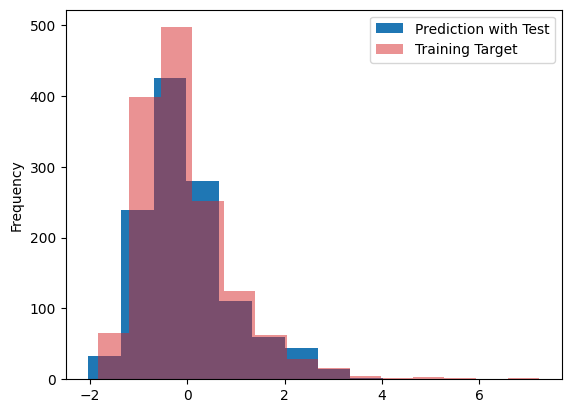

In [39]:
pd.Series(model.predict(X_test)).plot(kind="hist",label="Prediction with Test")
pd.Series(y[:,0]).plot(kind="hist",color="C3",alpha=.5,bins=14,label="Training Target")
plt.legend()

## 2. Random Forest

Continuing with the home price data we were looking at.

I'll use a reduced number of features from our LASSO example:

In [40]:
features = ['LotArea', 'OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea',
               'Fireplaces', 'GarageArea', 'Total_Home_Quality', 'TotalSF',
               'YrBltAndRemod', 'Total_Bathrooms', 'GarageCars_log_sq',
               'Neighborhood_NoRidge', 'ExterQual_Ex', 'ExterQual_TA', 'BsmtQual_Ex',
               'BsmtExposure_Gd', 'KitchenQual_Ex']

In [41]:
X = StandardScaler().fit_transform(df[features])

y = StandardScaler().fit_transform(df[['Saleprice']])

Now let's specify a smallish grid to search over:

In [42]:
number_trees = np.arange(200,2000,20)
max_depth = np.arange(10,110,10)
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': number_trees,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True,False]}

Now I'll instantiate a new model object:

In [43]:
rf = RandomForestRegressor()

While we could still use `GridSearch`, I'll use `RandomizedSearchCV` which will do it faster (since it does it randomly) at the expense of possibly not landing on the global min.

In [44]:
rf_random = RandomizedSearchCV(rf,random_grid,n_iter=20,n_jobs=-1,random_state=40)

rf_random.fit(X,y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': array([ 200,  220,  240,  260,  280,  300,  320,  340,  360,  380,  400,
        420,  440,  460,  480,  500,  520,  540,  560,  580,  600,  620,
        640,  660,  680,  700,  720,  740,  760,  780,  800,  820,  840,
        860,  880,  900,  920,  940,  960,  980, 1000, 1020, 1040, 1060,
       1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280,
       1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500,
       1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720,
       1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940,
       1960, 1980])},
                   random_state=40)

In [45]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_leaf': 1,
 'max_depth': 40,
 'bootstrap': True}

Now let's see how it looks:

In [46]:
df['y_hat_rf'] = rf_random.predict(X)

In [47]:
df['y_hat_rf']

0       0.323719
1      -0.059320
2       0.510272
3      -0.368175
4       1.150843
          ...   
1453   -0.071913
1454    0.362140
1455    0.962279
1456   -0.518628
1457   -0.424655
Name: y_hat_rf, Length: 1458, dtype: float64

In [48]:
df['y'] = y

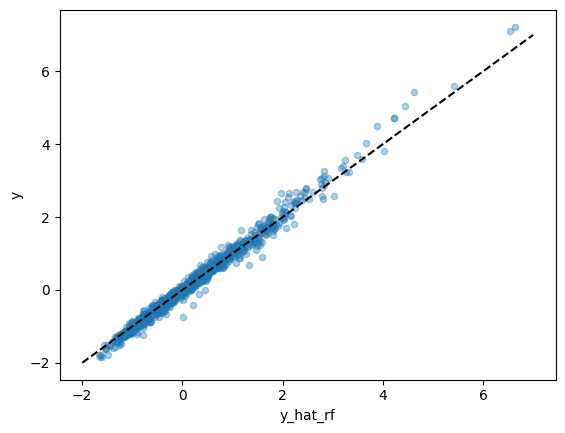

In [49]:
df[['y','y_hat_rf']].plot(kind='scatter',y="y",x='y_hat_rf',alpha=.35)
plt.plot(np.linspace(-2,7,10),np.linspace(-2,7,10),color="black",ls="--")

In [62]:
rmse_rf = ((df['y']-df['y_hat_rf'])**2).mean()**.5
rmse_rf

0.12046593477779845

Where is it predicting the worst?

Is this good or bad?

In [63]:
test[['sale_price_pred']].to_csv("rf_prices.csv",index=False)

## 3. DNN Example

Using our housing example, let's estimate a DNN and compare it to the results of the Random Forest.

This example borrows heavily from:

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb#scrollTo=F0qutYAKwoda

In the Tensorflow package, we can add a preprocessing step into the network itself:

In [64]:
normalizer = preprocessing.Normalization()

normalizer.adapt(X)

In the given code, they made a nice function that will build a two hidden layer, 64 neuron network given a normalization object.

In [65]:
def build_and_compile_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) # Notice this one only has one neuron, so it is the output layer.
              ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [66]:
model = build_and_compile_model(normalizer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 18)                37        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5478 (21.40 KB)
Trainable params: 5441 (21.25 KB)
Non-trainable params: 37 (152.00 Byte)
_________________________________________________________________


There are 5k parameters to train!

In [67]:
runs = model.fit(X,y,validation_split=0.2,
                    verbose=0, epochs=1000)

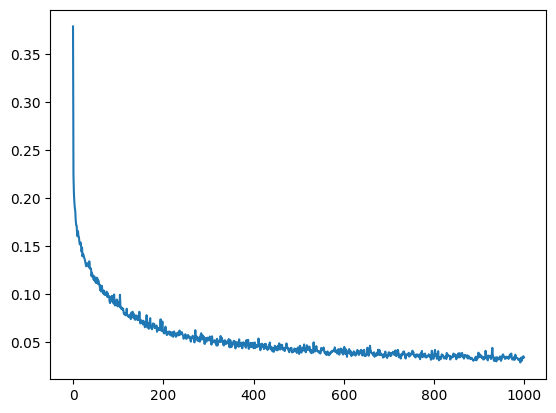

In [68]:
plt.plot(runs.history['loss'])

In [69]:
df['y_hat_dnn'] = model.predict(X)

46/46 [==============================] - 0s 1ms/step


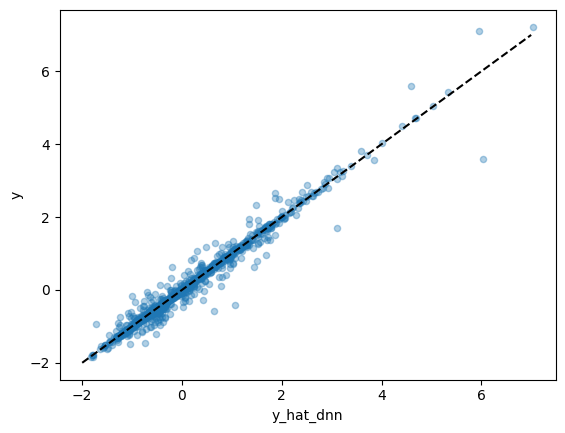

In [70]:
df[['y','y_hat_dnn']].plot(kind='scatter',y="y",x='y_hat_dnn',alpha=.35)
plt.plot(np.linspace(-2,7,10),np.linspace(-2,7,10),color="black",ls="--")

Now let's look at the RMSE

In [71]:
rmse_dnn = ((df['y']-df['y_hat_dnn'])**2).mean()**.5

In [72]:
rmse_dnn

0.1687120717009477

Let's compare all of the RMSEs

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Lasso'),
  Text(1, 0, 'Elastic Net'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'DNN')])

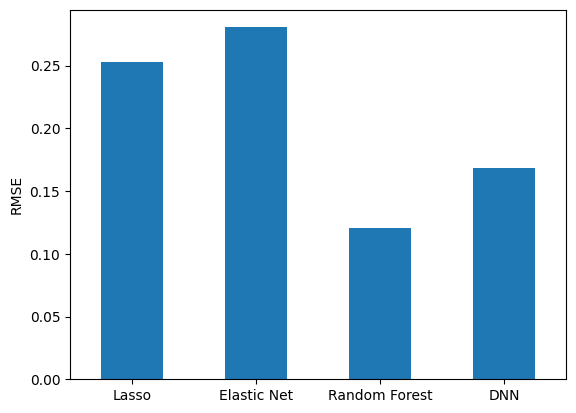

In [73]:
pd.Series([rmse_lasso,rmse_elast,rmse_rf,rmse_dnn],index=["Lasso","Elastic Net","Random Forest","DNN"]).plot(kind='bar')
plt.ylabel("RMSE")
plt.xticks(rotation=0)

So actually not as good as our Random Forest. Possibly this is because DNN is actually less helpful on smaller datasets.

We could likely get higher efficiency from trying to choose different neuron and hidden layer sizes.